Loaded MGFarm_18650_C01


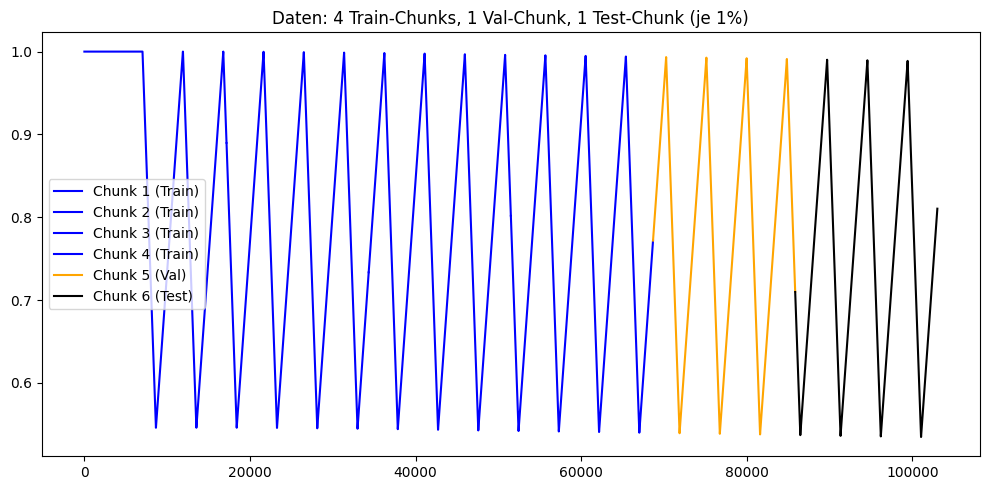

GPU wird genutzt!

===== EPOCH 1/20 =====


Epoch 1 done! Train MSE: 0.0077 | Val MSE: 0.0000

===== EPOCH 2/20 =====


Epoch 2 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 3/20 =====


Epoch 3 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 4/20 =====


Epoch 4 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 5/20 =====


Epoch 5 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 6/20 =====


Epoch 6 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 7/20 =====


Epoch 7 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 8/20 =====


Epoch 8 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 9/20 =====


Epoch 9 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 10/20 =====


Epoch 10 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 11/20 =====


Epoch 11 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 12/20 =====


Epoch 12 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 13/20 =====


Epoch 13 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 14/20 =====


Epoch 14 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 15/20 =====


Epoch 15 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 16/20 =====


Epoch 16 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 17/20 =====


Epoch 17 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 18/20 =====


Epoch 18 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 19/20 =====


Epoch 19 done! Train MSE: 0.0000 | Val MSE: 0.0000

===== EPOCH 20/20 =====


Epoch 20 done! Train MSE: 0.0000 | Val MSE: 0.0000

Finales Modell gespeichert unter: /home/florianr/MG_Farm/models/soc_lstm_final.pth


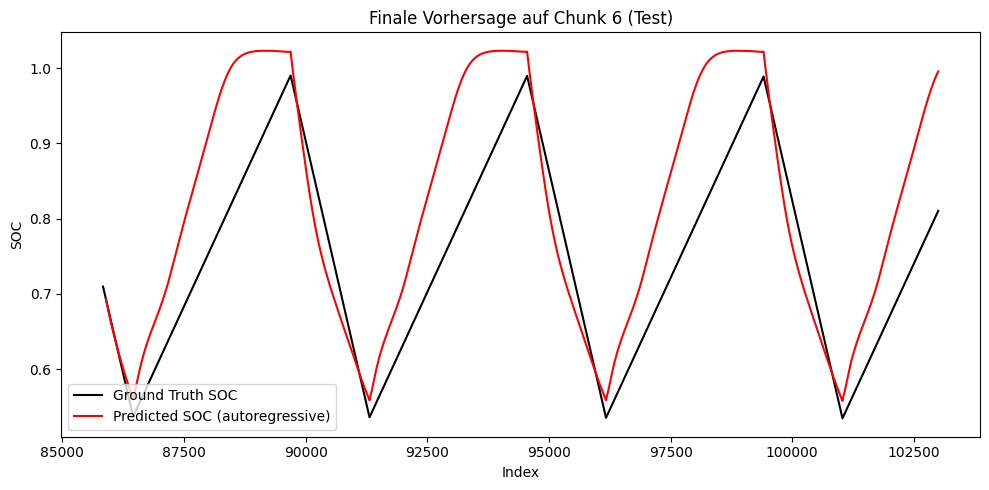

Fertig. Modell ist trainiert und wurde auf Chunk 6 getestet.


In [3]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from pytorch_forecasting.models.nn.rnn import LSTM  # changed import

###############################################################################
# 1) Laden der Daten
###############################################################################
def load_cell_data(data_dir: Path):
    """
    Lädt df_scaled.parquet aus dem Unterordner 'MGFarm_18650_C01'.
    """
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df_scaled.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df_scaled.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

###############################################################################
# 2) Datensatz-Klasse für Zeitsequenzen
###############################################################################
class SequenceDataset(Dataset):
    """
    Gibt (x_seq, y_next) für LSTM zurück:
      x_seq = (Scaled_Voltage, Scaled_Current, SOC) über seq_len Zeitschritte
      y_next = SOC[t+seq_len].
    """
    def __init__(self, data_array, seq_len=60):
        self.data_array = data_array
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data_array) - self.seq_len

    def __getitem__(self, idx):
        # N aufeinanderfolgende Zeitschritte
        x_seq = self.data_array[idx : idx + self.seq_len]  # shape (seq_len, 3)
        # SOC am Folgeschritt
        y_val = self.data_array[idx + self.seq_len, 2]     # SOC ist 3. Spalte
        x_seq_t = torch.tensor(x_seq, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.float32)
        return x_seq_t, y_val_t

###############################################################################
# 3) LSTM-Modell
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # letzter Zeitschritt im LSTM
        last_out = lstm_out[:, -1, :]
        # auf 1 Wert (SOC) runterprojizieren
        soc_pred = self.fc(last_out)  # (batch_size, 1)
        return soc_pred.squeeze(-1)   # (batch_size,)

###############################################################################
# 4) Autoregressive Vorhersage
###############################################################################
def predict_autoregressive(model, data_array, seq_len=60):
    """
    Autoregressive Vorhersage: Das Modell überschreibt ab t=seq_len den SOC 
    im Datenarray mit seiner eigenen Vorhersage.
    """
    # device automatisch aus dem Model-Parameter entnehmen
    device = next(model.parameters()).device

    model.eval()
    data_clone = data_array.copy()
    preds = np.full(len(data_clone), np.nan)

    with torch.no_grad():
        for i in range(seq_len, len(data_clone)):
            input_seq = data_clone[i - seq_len : i]  # (seq_len, 3)
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, 3)
            x_t = x_t.to(device)

            pred_soc = model(x_t).item()
            preds[i] = pred_soc
            # Autoregressiv: SOC-Spalte überschreiben
            data_clone[i, 2] = pred_soc

    return preds

###############################################################################
# 5) Hauptablauf - EIN finales Modell trainieren
###############################################################################
def main():
    # A) Daten laden
    data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
    cell_data = load_cell_data(data_dir)
    cell_keys = sorted(cell_data.keys())
    if not cell_keys:
        raise ValueError("Keine Zelle gefunden!")
    df_full = cell_data[cell_keys[0]]  # z.B. "C01"

    # B) Erzeuge 6 Häppchen à 1% Länge (ohne Shuffle)
    chunk_size = int(0.001 * len(df_full))
    if chunk_size < 1:
        raise ValueError("1% Chunk-Größe ist zu klein.")
    if 6 * chunk_size > len(df_full):
        print("WARNUNG: 6% ist größer als Datensatz, wir schneiden evtl. etwas ab.")

    chunks = []
    for i in range(6):
        start_i = i * chunk_size
        end_i   = start_i + chunk_size
        cdf = df_full.iloc[start_i:end_i].copy()
        chunks.append(cdf)

    # Wir definieren:
    #  - Chunks 1..4 (Index 0..3) = Training
    #  - Chunk 5   (Index 4)     = Validation
    #  - Chunk 6   (Index 5)     = Test
    train_data = pd.concat(chunks[0:4], axis=0)
    val_data   = chunks[4]
    test_data  = chunks[5]

    # Plot zur Illustration: Train, Val, Test
    plt.figure(figsize=(10,5))
    color_list = ["blue", "blue", "blue", "blue", "orange", "black"]
    label_list = ["Chunk 1 (Train)", "Chunk 2 (Train)", "Chunk 3 (Train)", "Chunk 4 (Train)",
                  "Chunk 5 (Val)", "Chunk 6 (Test)"]
    for i, cdf in enumerate(chunks):
        plt.plot(cdf.index, cdf["SOC_ZHU"], color=color_list[i], label=label_list[i])
    plt.title("Daten: 4 Train-Chunks, 1 Val-Chunk, 1 Test-Chunk (je 1%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # C) Tensor-Datasets
    seq_length = 60
    train_array = train_data[["Scaled_Voltage[V]", "Scaled_Current[A]", "SOC_ZHU"]].values
    val_array   = val_data[["Scaled_Voltage[V]", "Scaled_Current[A]", "SOC_ZHU"]].values
    test_array  = test_data[["Scaled_Voltage[V]", "Scaled_Current[A]", "SOC_ZHU"]].values

    train_dataset = SequenceDataset(train_array, seq_len=seq_length)
    val_dataset   = SequenceDataset(val_array,   seq_len=seq_length)

    # DataLoader
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True)

    # D) LSTM-Modell definieren
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMSOCModel(input_size=3, hidden_size=32, num_layers=1).to(device)

    if device.type == 'cuda':
        print("GPU wird genutzt!")
    else:
        print("ACHTUNG: GPU ist NICHT aktiv!")

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # E) Trainieren (z.B. 10 Epochen) mit Fortschrittsbalken pro Epoche UND pro Batch
    EPOCHS = 20
    try:
        for epoch in range(1, EPOCHS + 1):
            print(f"\n===== EPOCH {epoch}/{EPOCHS} =====")
            # -- TRAIN
            model.train()
            train_losses = []

            # Innerer Fortschrittsbalken für die Batches:
            train_loader_tqdm = tqdm(train_loader, desc=f"Train-Batches (Epoch {epoch})", leave=False)
            for x_batch, y_batch in train_loader_tqdm:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
                train_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}"})

            # -- VAL
            model.eval()
            val_losses = []
            val_loader_tqdm = tqdm(val_loader, desc=f"Val-Batches (Epoch {epoch})", leave=False)
            with torch.no_grad():
                for x_val, y_val in val_loader_tqdm:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred_val = model(x_val)
                    val_loss = criterion(y_pred_val, y_val)
                    val_losses.append(val_loss.item())
                    val_loader_tqdm.set_postfix({"val_loss": f"{val_loss.item():.4f}"})
            mean_train = np.mean(train_losses)
            mean_val   = np.mean(val_losses)
            print(f"Epoch {epoch} done! Train MSE: {mean_train:.4f} | Val MSE: {mean_val:.4f}")
    except KeyboardInterrupt:
        print("\nTraining unterbrochen. Speichere Modell...")

    # F) Fertiges Modell speichern (optional) in /home/florianr/MG_Farm/models/
    model_dir = Path("/home/florianr/MG_Farm/models")
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / "soc_lstm_final.pth"
    torch.save(model.state_dict(), model_path)
    print(f"\nFinales Modell gespeichert unter: {model_path}")

    # G) Test: Autoregressive Vorhersage auf Chunk 6
    preds_test = predict_autoregressive(model, test_array, seq_len=seq_length)
    gt_test = test_data["SOC_ZHU"].values

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(test_data.index, gt_test, label="Ground Truth SOC", color='k')
    plt.plot(test_data.index, preds_test, label="Predicted SOC (autoregressive)", color='r')
    plt.title("Finale Vorhersage auf Chunk 6 (Test)")
    plt.xlabel("Index")
    plt.ylabel("SOC")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("Fertig. Modell ist trainiert und wurde auf Chunk 6 getestet.")

# Falls du das Skript direkt ausführst:
if __name__ == "__main__":
    main()
